In [1]:
import numpy as np 
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import copy, os, sys

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


f:\developer\Anaconda\envs\Time_fore\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 构建模型

In [2]:
#LSTM
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1
        self.batch_size = batch_size
        self.lstm = nn.LSTM((self.input_size), (self.hidden_size), (self.num_layers), batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input_seq):
        batch_size, seq_len = input_seq.shape[0], input_seq.shape[1]
        h_0 = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(device)
        c_0 = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(device)
        output, _ = self.lstm(input_seq, (h_0, c_0))
        pred = self.linear(output)
        pred = pred[:, -1, :] # 对于每一个批次，我们选择最后一个时间步的所有输出特征,张量维度：(batch_size, sequence_length, output_size)
        return pred

#双LSTM层
class LSTM_2cells(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.input_size = args.input_size
        self.output_size = args.output_size
        self.num_directions = 1
        self.batch_size = args.batch_size
        self.lstm0 = nn.LSTMCell(args.input_size, hidden_size=128)
        self.lstm1 = nn.LSTMCell(input_size=128, hidden_size=32)
        self.dropout = nn.Dropout(p=0.4)
        self.linear = nn.Linear(32, self.output_size)

    def forward(self, input_seq):
        batch_size, seq_len = input_seq.shape[0], input_seq.shape[1]
        # batch_size, hidden_size
        h_l0 = torch.zeros(batch_size, 128).to(device)
        c_l0 = torch.zeros(batch_size, 128).to(device)
        h_l1 = torch.zeros(batch_size, 32).to(device)
        c_l1 = torch.zeros(batch_size, 32).to(device)
        output = []
        for t in range(seq_len):
            h_l0, c_l0 = self.lstm0(input_seq[:, t, :], (h_l0, c_l0))
            h_l0, c_l0 = self.dropout(h_l0), self.dropout(c_l0)
            h_l1, c_l1 = self.lstm1(h_l0, (h_l1, c_l1))
            h_l1, c_l1 = self.dropout(h_l1), self.dropout(c_l1)
            output.append(h_l1)

        pred = self.linear(output[-1])

        return pred



#双向LSTM（模型在初始化隐藏状态 h o 和 c时，使用了固定的批量大小self.batch size 。这意味着，无论输入数据的批量大小是多少，隐藏状态的批量大小总是固定的。这就是为什么当输入数据的批量大小不等于self.batch size 时，你会遇到问题）
# class BiLSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size):
#         super().__init__()
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.output_size = output_size
#         self.num_directions = 2
#         self.batch_size = batch_size
#         self.lstm = nn.LSTM((self.input_size), (self.hidden_size), (self.num_layers), batch_first=True, bidirectional=True)
#         self.linear = nn.Linear(self.num_directions * self.hidden_size, self.output_size)

#     def forward(self, input_seq):
#         h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
#         c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
#         # print(input_seq.size())
#         seq_len = input_seq.shape[1]
#         # input(batch_size, seq_len, input_size)
#         # output(batch_size, seq_len, num_directions * hidden_size)
#         output, _ = self.lstm(input_seq, (h_0, c_0))
#         pred = self.linear(output)  # pred()
#         pred = pred[:, -1, :]
        
#         return pred
    
class BiLSTM(nn.Module):#(在前向传播时.通过 input seq.size(o)动态地获取批量大小，然后用这个批量大小来初始化隐藏状态,避免最后一个批次样本量不足时，导致批次大小和预期的不匹配)
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 2
        self.lstm = nn.LSTM((self.input_size), (self.hidden_size), (self.num_layers), batch_first=True, bidirectional=True)
        self.linear = nn.Linear(self.num_directions * self.hidden_size, self.output_size)

    def forward(self, input_seq):
        batch_size = input_seq.size(0)  # 动态获取批量大小
        h_0 = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(device)
        c_0 = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(device)
        output, _ = self.lstm(input_seq, (h_0, c_0))
        pred = self.linear(output)
        pred = pred[:, -1, :]
        
        return pred

#编码器，采用了LSTM将原始数据进行编码，然后将LSTM的最后的隐状态和单元状态返回。
class Encoder(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, batch_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 1
        self.batch_size = batch_size
        self.lstm = nn.LSTM((self.input_size), (self.hidden_size), (self.num_layers), batch_first=True, bidirectional=False)

    def forward(self, input_seq):
        batch_size, seq_len = input_seq.shape[0], input_seq.shape[1]
        h_0 = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(device)
        c_0 = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(device)
        output, (h, c) = self.lstm(input_seq, (h_0, c_0))
        return (
         h, c)

#解码器，解码器同样也由LSTM组成，不过解码器的初始的隐状态和单元状态是编码器的输出。此外，解码器每次输入都是上次的输出。
class Decoder(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1
        self.batch_size = batch_size
        self.lstm = nn.LSTM((self.input_size), (self.hidden_size), (self.num_layers), batch_first=True, bidirectional=False)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input_seq, h, c):
        batch_size = input_seq.shape[0]
        input_seq = input_seq.view(batch_size, 1, self.input_size)
        output, (h, c) = self.lstm(input_seq, (h, c))
        pred = self.linear(output)
        pred = pred[:, -1, :]
        return (
         pred, h, c)

#seq2seq
class Seq2Seq(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size):
        super().__init__()
        self.output_size = output_size
        self.Encoder = Encoder(input_size, hidden_size, num_layers, batch_size)
        self.Decoder = Decoder(input_size, hidden_size, num_layers, output_size, batch_size)

    def forward(self, input_seq):
        batch_size, seq_len, _ = input_seq.shape[0], input_seq.shape[1], input_seq.shape[2]
        h, c = self.Encoder(input_seq)
        outputs = torch.zeros(batch_size, seq_len, self.output_size).to(device)
        for t in range(seq_len):
            _input = input_seq[:, t, :]
            output, h, c = self.Decoder(_input, h, c)
            outputs[:, t, :] = output

        return outputs[:, -1, :]

#多任务学习LSTM模型
class MTL_LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size, n_outputs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1
        self.n_outputs = n_outputs
        self.batch_size = batch_size
        self.lstm = nn.LSTM((self.input_size), (self.hidden_size), (self.num_layers), batch_first=True)
        self.fc1 = nn.Linear(self.hidden_size, self.output_size)
        self.fc2 = nn.Linear(self.hidden_size, self.output_size)
        self.fc3 = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input_seq):
        batch_size, seq_len = input_seq.shape[0], input_seq.shape[1]
        h_0 = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(device)
        c_0 = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(device)
        output, _ = self.lstm(input_seq, (h_0, c_0))
        preds = []
        pred1, pred2, pred3 = self.fc1(output), self.fc2(output), self.fc3(output)
        pred1, pred2, pred3 = pred1[:, -1, :], pred2[:, -1, :], pred3[:, -1, :]
        pred = torch.stack([pred1, pred2, pred3], dim=0)
        return pred
    

# 构建卷积神经网络模型
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.B = B
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=2),  # 24 - 2 + 1 = 23
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=1),  # 23 - 2 + 1 = 22
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=2),  # 22 - 2 + 1 = 21
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),  # 21 - 2 + 1 = 20
        )
        self.Linear1 = nn.Linear(self.B * 127 * 20, self.B * 50)
        self.Linear2 = nn.Linear(self.B * 50, self.B)

    def forward(self, x):
        # (batch size, channel, series length)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1)
        x = self.Linear1(x)
        x = self.relu(x)
        x = self.Linear2(x)

        x = x.view(x.shape[0], -1)

        return x

class CNN_LSTM(nn.Module):
    def __init__(self, args):
        super(CNN_LSTM, self).__init__()
        self.args = args
        self.relu = nn.ReLU(inplace=True)
        # (batch_size=30, seq_len=24, input_size=7) ---> permute(0, 2, 1)
        # (30, 7, 24)
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=args.in_channels, out_channels=args.out_channels, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=1)
        )
        # (batch_size=30, out_channels=32, seq_len-4=20) ---> permute(0, 2, 1)
        # (30, 20, 32)
        self.lstm = nn.LSTM(input_size=args.out_channels, hidden_size=args.hidden_size,
                            num_layers=args.num_layers, batch_first=True)
        self.fc = nn.Linear(args.hidden_size, args.output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = self.fc(x)
        x = x[:, -1, :]

        return x
import math
#位置编码
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, args):
        super(TransformerModel, self).__init__()
        self.args = args
        # embed_dim = head_dim * num_heads?
        self.input_fc = nn.Linear(args.input_size, args.d_model)
        self.output_fc = nn.Linear(args.input_size, args.d_model)
        self.pos_emb = PositionalEncoding(args.d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=args.d_model,
            nhead=8,
            dim_feedforward=4 * args.d_model,
            batch_first=True,
            dropout=0.1,
            device=device
        )
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=args.d_model,
            nhead=8,
            dropout=0.1,
            dim_feedforward=4 * args.d_model,
            batch_first=True,
            device=device
        )
        self.encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=5)
        self.decoder = torch.nn.TransformerDecoder(decoder_layer, num_layers=5)
        self.fc = nn.Linear(args.output_size * args.d_model, args.output_size)
        self.fc1 = nn.Linear(args.seq_len * args.d_model, args.d_model)
        self.fc2 = nn.Linear(args.d_model, args.output_size)

    def forward(self, x):
        # print(x.size())  # (256, 24, 7)
        y = x[:, -self.args.output_size:, :]
        # print(y.size())  # (256, 4, 7)
        x = self.input_fc(x)  # (256, 24, 128)
        x = self.pos_emb(x)   # (256, 24, 128)
        x = self.encoder(x)
        # 不经过解码器
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        out = self.fc2(x)
        # y = self.output_fc(y)   # (256, 4, 128)
        # out = self.decoder(y, x)  # (256, 4, 128)
        # out = out.flatten(start_dim=1)  # (256, 4 * 128)
        # out = self.fc(out)  # (256, 4)

        return out



# 数据集和特征处理部分

In [3]:
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, item):
        return self.data[item]

    def __len__(self):
        return len(self.data)

In [4]:

# 加载数据，填充缺失值
def load_data(file_name):
    """
    :return: dataframe
    """
    path = os.path.dirname(os.getcwd()) + '/data/' + file_name
    df = pd.read_csv(path, encoding='gbk')
    num_cols = df.columns[1:]  # 获取除第0列外的每一列名称(第0列的时间类型无法求均值)
    df[num_cols].fillna(df[num_cols].mean(), inplace=True) #填补缺失值
    return df

In [5]:
import numpy as np
from sklearn import metrics
#预测统计指标
def get_rmse(y_true, y_pred): #均方根误差
    return np.sqrt(metrics.mean_squared_error(y_true, y_pred))

def get_mape(y_true, y_pred):#平均绝对百分比误差
    """
    :param y_true: true value
    :param y_pred: pred value
    :return: mape
    """
    return np.mean(np.abs((y_pred - y_true) / y_true)) *100

def get_smape(y_true, y_pred): #对称平均绝对百分比误差
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) *100


In [6]:
# 根据flag选择处理数据,返回训练集、验证集、测试集、最大值、最小值
def data_process(dataset,args, flag):
    if flag == 'us':
        Dtr, Val, Dte, m, n = nn_seq_us(dataset,seq_len=(args.seq_len), B=(args.batch_size))
    elif flag == 'ms':
        Dtr, Val, Dte, m, n = nn_seq_ms(dataset,seq_len=(args.seq_len), B=(args.batch_size))
    elif flag == 'mm':
        Dtr, Val, Dte, m, n = nn_seq_mm(dataset,seq_len=(args.seq_len), B=(args.batch_size), num=(args.output_size))
    elif flag == 'mms' or flag == 'mmss':
        Dtr, Val, Dte, m, n = nn_seq_mmss(dataset,seq_len=(args.seq_len), B=(args.batch_size), pred_step_size=(args.pred_step_size))
    elif flag == 'mo' or flag == 'seq2seq':
        Dtr, Val, Dte, m, n = nn_seq_mo(dataset,seq_len=(args.seq_len), B=(args.batch_size), num=(args.output_size))
    elif flag == 'sss':#单步滚动预测
        Dtr, Val, Dte, m, n = nn_seq_sss(dataset,seq_len=(args.seq_len), B=(args.batch_size))

    return (Dtr, Val, Dte, m, n)

# 单变量单步 处理数据
def nn_seq_us(dataset,seq_len, B):
    print('data processing...')
    train = dataset[:int(len(dataset) * 0.6)]
    val = dataset[int(len(dataset) * 0.6):int(len(dataset) * 0.8)]
    test = dataset[int(len(dataset) * 0.8):len(dataset)]
    m, n = np.max(train[train.columns[1]]), np.min(train[train.columns[1]])

    def process(data, batch_size):
        load = data[data.columns[1]]
        data = data.values.tolist()
        load = (load - n) / (m - n) #归一化
        load = load.tolist()
        seq = []
        for i in range(len(data) - seq_len):
            train_seq = []
            train_label = []
            for j in range(i, i + seq_len):
                x = [
                 load[j]]
                train_seq.append(x)

            train_label.append(load[(i + seq_len)])
            train_seq = torch.FloatTensor(train_seq)
            train_label = torch.FloatTensor(train_label).view(-1)
            seq.append((train_seq, train_label))

        seq = MyDataset(seq)
        seq = DataLoader(dataset=seq, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=False)
        return seq

    Dtr = process(train, B)
    Val = process(val, B)
    Dte = process(test, B)
    return (
     Dtr, Val, Dte, m, n)

# 多变量单步 处理数据
def nn_seq_ms(dataset,seq_len, B):
    print('data processing...')
    train = dataset[:int(len(dataset) * 0.6)]
    val = dataset[int(len(dataset) * 0.6):int(len(dataset) * 0.8)]
    test = dataset[int(len(dataset) * 0.8):len(dataset)]
    m, n = np.max(train[train.columns[1]]), np.min(train[train.columns[1]])

    def process(data, batch_size):
        load = data[data.columns[1]]
        data = data.values.tolist()
        load = (load - n) / (m - n)
        load = load.tolist()
        seq = []
        for i in range(len(data) - seq_len):
            train_seq = []
            train_label = []
            for j in range(i, i + seq_len):
                x = [
                 load[j]]
                for c in range(2, 8):
                    x.append(data[j][c])

                train_seq.append(x) 

            train_label.append(load[(i + seq_len)])
            train_seq = torch.FloatTensor(train_seq)
            train_label = torch.FloatTensor(train_label).view(-1)
            seq.append((train_seq, train_label))

        seq = MyDataset(seq)
        seq = DataLoader(dataset=seq, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=False) #最后一个批次不满足30
        return seq

    Dtr = process(train, B)
    Val = process(val, B)
    Dte = process(test, B)
    return (
     Dtr, Val, Dte, m, n)

# 多变量多步 处理数据
def nn_seq_mm(dataset,seq_len, B, num): #num为预测步长
    print('data processing...')
    train = dataset[:int(len(dataset) * 0.6)]
    val = dataset[int(len(dataset) * 0.6):int(len(dataset) * 0.8)]
    test = dataset[int(len(dataset) * 0.8):len(dataset)]
    m, n = np.max(train[train.columns[1]]), np.min(train[train.columns[1]])

    def process(data, batch_size, step_size):
        load = data[data.columns[1]]
        data = data.values.tolist()
        load = (load - n) / (m - n)
        load = load.tolist()
        # 根据给定的步长 step_size，从数据集中提取输入序列和对应的目标标签
        seq = []
        for i in range(0, len(data) - seq_len - num, step_size):
            train_seq = []
            train_label = []
            for j in range(i, i + seq_len):
                x = [
                 load[j]]
                for c in range(2, 8):
                    x.append(data[j][c])

                train_seq.append(x)

            for j in range(i + seq_len, i + seq_len + num):
                train_label.append(load[j])

            train_seq = torch.FloatTensor(train_seq)
            train_label = torch.FloatTensor(train_label).view(-1)
            seq.append((train_seq, train_label))

        seq = MyDataset(seq)
        seq = DataLoader(dataset=seq, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=False)
        return seq

    Dtr = process(train, B, step_size=1)
    Val = process(val, B, step_size=1)
    Dte = process(test, B, step_size=num)
    return (
     Dtr, Val, Dte, m, n)

#seq2seq和直接多输出
def nn_seq_mo(data,seq_len, B, num):
    # 数据划分
    train = data[:int(len(data) * 0.6)]
    val = data[int(len(data) * 0.6):int(len(data) * 0.8)]
    test = data[int(len(data) * 0.8):len(data)]
    m, n = np.max(train[train.columns[1]]), np.min(train[train.columns[1]])

    def process(dataset, batch_size, step_size):
        load = dataset[dataset.columns[1]]
        load = (load - n) / (m - n)  # 归一化
        load = load.tolist()
        dataset = dataset.values.tolist()
        #序列和标签
        seq = []
        for i in range(0, len(dataset) - seq_len - num, step_size):
            train_seq = []
            train_label = []
            for j in range(i, i + seq_len):
                x = [
                 load[j]]
                for c in range(2, 8):
                    x.append(dataset[j][c])

                train_seq.append(x)

            for j in range(i + seq_len, i + seq_len + num):
                train_label.append(load[j])
            #pytorch张量
            train_seq = torch.FloatTensor(train_seq)
            train_label = torch.FloatTensor(train_label).view(-1)
            seq.append((train_seq, train_label))

        seq = MyDataset(seq)
        seq = DataLoader(dataset=seq, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
        return seq

    Dtr = process(train, B, step_size=1)
    Val = process(val, B, step_size=1)
    Dte = process(test, B, step_size=num)
    return (
     Dtr, Val, Dte, m, n)

#单步滚动预测
def nn_seq_sss(data,seq_len, B):
    train = data[:int(len(data) * 0.6)]
    val = data[int(len(data) * 0.6):int(len(data) * 0.8)]
    test = data[int(len(data) * 0.8):len(data)]
    m, n = np.max(train[train.columns[1]]), np.min(train[train.columns[1]])

    def process(dataset, batch_size):
        load = dataset[dataset.columns[1]]
        load = (load - n) / (m - n)
        load = load.tolist()
        dataset = dataset.values.tolist()
        seq = []
        for i in range(len(dataset) - seq_len):
            train_seq = []
            train_label = []
            for j in range(i, i + seq_len):
                x = [
                 load[j]]
                for c in range(2, 8):
                    x.append(dataset[j][c])

                train_seq.append(x)

            train_label.append(load[(i + seq_len)])
            train_seq = torch.FloatTensor(train_seq)
            train_label = torch.FloatTensor(train_label).view(-1)
            seq.append((train_seq, train_label))

        seq = MyDataset(seq)
        seq = DataLoader(dataset=seq, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
        return seq

    Dtr = process(train, B)
    Val = process(val, B)
    Dte = process(test, B)
    return (
     Dtr, Val, Dte, m, n)

#多模型滚动和多模型
def nn_seq_mmss(data,seq_len, B, pred_step_size):
    train = data[:int(len(data) * 0.6)]
    val = data[int(len(data) * 0.6):int(len(data) * 0.8)]
    test = data[int(len(data) * 0.8):len(data)]
    m, n = np.max(train[train.columns[1]]), np.min(train[train.columns[1]])

    def process(dataset, batch_size, step_size):
        load = dataset[dataset.columns[1]]
        load = (load - n) / (m - n)
        dataset = dataset.values.tolist()
        load = load.tolist()
        seqs = [[] for i in range(pred_step_size)]
        for i in range(0, len(dataset) - seq_len - pred_step_size, step_size):
            train_seq = []
            for j in range(i, i + seq_len):
                x = [
                 load[j]]
                for c in range(2, 8):
                    x.append(dataset[j][c])

                train_seq.append(x)

            for j, ind in zip(range(i + seq_len, i + seq_len + pred_step_size), range(pred_step_size)):
                train_label = [
                 load[j]]
                seq = torch.FloatTensor(train_seq)
                train_label = torch.FloatTensor(train_label).view(-1)
                seqs[ind].append((seq, train_label))

        res = []
        for seq in seqs:
            seq = MyDataset(seq)
            seq = DataLoader(dataset=seq, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
            res.append(seq)

        return res

    Dtrs = process(train, B, step_size=1)
    Vals = process(val, B, step_size=1)
    Dtes = process(test, B, step_size=pred_step_size)
    return (
     Dtrs, Vals, Dtes, m, n)


from sklearn.preprocessing import MinMaxScaler
#多任务学习
def nn_seq_mtl(seq_len, B, pred_step_size):
    data = load_data(r'../data/mtl_data_2.csv')
    train = data[:int(len(data) * 0.6)]
    val = data[int(len(data) * 0.6):int(len(data) * 0.8)]
    test = data[int(len(data) * 0.8):len(data)]
    train.drop([train.columns[0]], axis=1, inplace=True)
    val.drop([val.columns[0]], axis=1, inplace=True)
    test.drop([test.columns[0]], axis=1, inplace=True)
    scaler = MinMaxScaler()
    train = scaler.fit_transform(train.values)
    val = scaler.transform(val.values)
    test = scaler.transform(test.values)

    def process(dataset, batch_size, step_size):
        dataset = dataset.tolist()
        seq = []
        for i in range(0, len(dataset) - seq_len - pred_step_size, step_size):
            train_seq = []
            for j in range(i, i + seq_len):
                x = []
                for c in range(len(dataset[0])):
                    x.append(dataset[j][c])

                train_seq.append(x)

            train_labels = []
            for j in range(len(dataset[0])):
                train_label = []
                for k in range(i + seq_len, i + seq_len + pred_step_size):
                    train_label.append(dataset[k][j])

                train_labels.append(train_label)

            train_seq = torch.FloatTensor(train_seq)
            train_labels = torch.FloatTensor(train_labels)
            seq.append((train_seq, train_labels))

        seq = MyDataset(seq)
        seq = DataLoader(dataset=seq, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
        return seq

    Dtr = process(train, B, step_size=1)
    Val = process(val, B, step_size=1)
    Dte = process(test, B, step_size=pred_step_size)
    return (
     Dtr, Val, Dte, scaler)


In [7]:
# 计算验证集的损失值
def get_val_loss(args, model, Val):
    model.eval()
    loss_function = nn.MSELoss().to(args.device)
    val_loss = []
    for seq, label in Val:
        with torch.no_grad():
            seq = seq.to(args.device)
            label = label.to(args.device)
            y_pred = model(seq)
            loss = loss_function(y_pred, label)
            val_loss.append(loss.item())

    return np.mean(val_loss)


def CNN_get_val_loss(model, Val):
    model.eval()
    loss_function = nn.MSELoss().to(device)
    val_loss = []
    for (seq, label) in Val:
        with torch.no_grad():
            seq = seq.to(device)
            label = label.to(device)
            y_pred = model(seq)
            loss = loss_function(y_pred, label)
            val_loss.append(loss.item())

    return np.mean(val_loss)

In [8]:
import random
# 用于设置随机种子，以确保在训练模型时的可重复性
def setup_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [9]:
# 训练模型

import matplotlib.pyplot as plt

def train(args, Dtr, Val, path, flags=0):
    input_size, hidden_size, num_layers = args.input_size, args.hidden_size, args.num_layers
    output_size = args.output_size
    if args.bidirectional:
        model = BiLSTM(input_size, hidden_size, num_layers, output_size).to(device)
    else:
        model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=(args.batch_size)).to(device)
    if flags == 1: #多层LSTM
        model = LSTM_2cells(args).to(device)
    if flags==2: #CNN_LSTM
        model=CNN_LSTM(args).to(device)
    if flags==3: #Transformer
        model=TransformerModel(args).to(device)
    loss_function = nn.MSELoss().to(device)
    if args.optimizer == 'adam':
        optimizer = torch.optim.Adam((model.parameters()), lr=(args.lr), weight_decay=(args.weight_decay))
    else:
        optimizer = torch.optim.SGD((model.parameters()), lr=(args.lr), momentum=0.9,
          weight_decay=(args.weight_decay))
    scheduler = StepLR(optimizer, step_size=(args.step_size), gamma=(args.gamma))
    min_epochs = 10
    best_model = None
    min_val_loss = 5
    train_losses = []
    val_losses = []
    count = 0 #早停计数

    for epoch in tqdm(range(args.epochs)):
        train_loss = []
        for seq, label in Dtr:
            seq = seq.to(device)
            label = label.to(device)
            y_pred = model(seq)
            loss = loss_function(y_pred, label)
            train_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        scheduler.step()
        val_loss = get_val_loss(args, model, Val)
        train_losses.append(np.mean(train_loss))
        val_losses.append(val_loss)
        if epoch + 1 >= min_epochs:
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                best_model = copy.deepcopy(model)
                count = 0
            else:
                count += 1
                if count >= 50:
                    print("Early stopping")
                    break
        if (epoch + 1) % 50 == 0:
            print('epoch {:03d} train_loss {:.8f} val_loss {:.8f}'.format(epoch, np.mean(train_loss), val_loss))
        model.train()

    state = {'models': best_model.state_dict()}
    torch.save(state, path)

    # 绘制训练损失和测试损失的变化
    # plt.plot(range(len(train_losses)), train_losses, label='train_loss')
    # plt.plot(range(len(val_losses)), val_losses, label='val_loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.show()
    # state = {'models': best_model.state_dict()}
    # torch.save(state, path)
    
#seq2seq的训练函数
def seq2seq_train(args, Dtr, Val, path):
    input_size, hidden_size, num_layers = args.input_size, args.hidden_size, args.num_layers
    output_size = args.output_size
    batch_size = args.batch_size
    model = Seq2Seq(input_size, hidden_size, num_layers, output_size, batch_size=batch_size).to(device)
    loss_function = nn.MSELoss().to(device)
    if args.optimizer == 'adam':
        optimizer = torch.optim.Adam((model.parameters()), lr=(args.lr), weight_decay=(args.weight_decay))
    else:
        optimizer = torch.optim.SGD((model.parameters()), lr=(args.lr), momentum=0.9,
          weight_decay=(args.weight_decay))
    scheduler = StepLR(optimizer, step_size=(args.step_size), gamma=(args.gamma))
    min_epochs = 10
    best_model = None
    min_val_loss = 5
    for epoch in tqdm(range(args.epochs)):
        train_loss = []
        for seq, label in Dtr:
            seq = seq.to(device)
            label = label.to(device)
            y_pred = model(seq)
            loss = loss_function(y_pred, label)
            train_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        scheduler.step()
        val_loss = get_val_loss(args, model, Val)
        if epoch > min_epochs:
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                best_model = copy.deepcopy(model)
        if (epoch + 1) % 50 == 0:
            print('epoch {:03d} train_loss {:.8f} val_loss {:.8f}'.format(epoch, np.mean(train_loss), val_loss))
        model.train()

    state = {'models': best_model.state_dict()}
    torch.save(state, path)

#计算多任务学习模型的损失
def get_mtl_val_loss(args, model, Val):
    model.eval()
    loss_function = nn.MSELoss().to(args.device)
    val_loss = []
    for seq, labels in Val:
        seq = seq.to(device)
        labels = labels.to(device)
        preds = model(seq)
        total_loss = 0
        for k in range(args.n_outputs):
            total_loss = total_loss + loss_function(preds[k, :, :], labels[:, k, :])

        total_loss /= preds.shape[0]
        val_loss.append(total_loss.item())

    return np.mean(val_loss)

#多任务学习的训练函数
def mtl_train(args, Dtr, Val, path):
    input_size, hidden_size, num_layers = args.input_size, args.hidden_size, args.num_layers
    output_size = args.output_size
    model = MTL_LSTM(input_size, hidden_size, num_layers, output_size, batch_size=(args.batch_size), n_outputs=(args.n_outputs)).to(device)
    loss_function = nn.MSELoss().to(device)
    if args.optimizer == 'adam':
        optimizer = torch.optim.Adam((model.parameters()), lr=(args.lr), weight_decay=(args.weight_decay))
    else:
        optimizer = torch.optim.SGD((model.parameters()), lr=(args.lr), momentum=0.9,
          weight_decay=(args.weight_decay))
    scheduler = StepLR(optimizer, step_size=(args.step_size), gamma=(args.gamma))
    min_epochs = 10
    best_model = None
    min_val_loss = 5
    for epoch in tqdm(range(args.epochs)):
        train_loss = []
        for seq, labels in Dtr:
            seq = seq.to(device)
            labels = labels.to(device)
            preds = model(seq)
            total_loss = 0
            for k in range(args.n_outputs):#对每一个output计算损失然后相加求平均
                total_loss = total_loss + loss_function(preds[k, :, :], labels[:, k, :])
            total_loss /= preds.shape[0]

            train_loss.append(total_loss.item())
            total_loss.requires_grad_(True)
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

        scheduler.step()
        val_loss = get_mtl_val_loss(args, model, Val)
        if epoch + 1 >= min_epochs:
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                best_model = copy.deepcopy(model)
        if (epoch + 1) % 50 == 0:
            print('epoch {:03d} train_loss {:.8f} val_loss {:.8f}'.format(epoch, np.mean(train_loss), val_loss))
        model.train()

    state = {'models': best_model.state_dict()}
    torch.save(state, path)

def CNN_train(Dtr, Val,CNN_PATH):
    model = CNN().to(device)
    loss_function = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    print('training...')
    epochs = 50
    min_epochs = 10
    best_model = None
    min_val_loss = 5
    for epoch in range(epochs):
        train_loss = []
        for batch_idx, (seq, target) in enumerate(Dtr, 0):
            seq, target = seq.to(device), target.to(device)
            optimizer.zero_grad()
            y_pred = model(seq)
            # print('y_pred=', y_pred, 'target=', target)
            loss = loss_function(y_pred, target)
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        # validation
        val_loss = CNN_get_val_loss(model, Val)
        if epoch + 1 >= min_epochs and val_loss < min_val_loss:
            min_val_loss = val_loss
            best_model = copy.deepcopy(model)

        print('epoch {:03d} train_loss {:.8f} val_loss {:.8f}'.format(epoch, np.mean(train_loss), val_loss))
        model.train()

    state = {'model': best_model.state_dict(), 'optimizer': optimizer.state_dict()}
    os.makedirs(os.path.dirname(CNN_PATH), exist_ok=True)  # 创建父目录（如果不存在）
    torch.save(state, CNN_PATH)

In [10]:
from itertools import chain
from scipy.interpolate import make_interp_spline

# 测试模型
def test(args, Dte, path, m, n,flags=0):
    pred = []
    y = []
    print('loading models...')
    input_size, hidden_size, num_layers = args.input_size, args.hidden_size, args.num_layers
    output_size = args.output_size
    if args.bidirectional:
        model = BiLSTM(input_size, hidden_size, num_layers, output_size).to(device)
    else:
        model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=(args.batch_size)).to(device)
    if flags == 1:
        model = LSTM_2cells(args).to(device)
    if flags==2:
        model=CNN_LSTM(args).to(device)
    if flags==3:
        model=TransformerModel(args).to(device)
    model.load_state_dict(torch.load(path)['models'])
    model.eval()
    print('predicting...')
    for seq, target in tqdm(Dte):
        target = list(chain.from_iterable(target.data.tolist()))
        y.extend(target)
        seq = seq.to(device)
        with torch.no_grad():
            y_pred = model(seq)
            y_pred = list(chain.from_iterable(y_pred.data.tolist()))
            pred.extend(y_pred)

    y, pred = np.array(y), np.array(pred)
    y = (m - n) * y + n
    pred = (m - n) * pred + n
    print('rmse:', get_rmse(y, pred))
    print('mape:', get_mape(y, pred))
    print('smape:', get_smape(y, pred))

    x = [i for i in range(1, 151)]
    x_smooth = np.linspace(np.min(x), np.max(x), 900)
    y_smooth = make_interp_spline(x, y[150:300])(x_smooth)
    plt.plot(x_smooth, y_smooth, c='green', marker='*', ms=1, alpha=0.75, label='true')
    y_smooth = make_interp_spline(x, pred[150:300])(x_smooth)
    plt.plot(x_smooth, y_smooth, c='red', marker='o', ms=1, alpha=0.75, label='pred')
    plt.grid(axis='y')
    plt.legend()
    #os.environ['KMP_DUPLICATE_LIB_OK']='True'
    # plt.savefig(r"../result/单步单变量预测.png")
    plt.show()

def CNN_test(Dte, m, n,CNN_PATH):
    cnn = CNN().to(device)
    cnn.load_state_dict(torch.load(CNN_PATH)['model'])
    cnn.eval()
    pred = []
    y = []
    for batch_idx, (seq, target) in enumerate(Dte, 0):
        seq = seq.to(device)
        with torch.no_grad():
            target = list(chain.from_iterable(target.tolist()))
            y.extend(target)
            pred.extend(cnn(seq).tolist())

    y, pred = np.array(y), np.array(pred)

    y = (m - n) * y + n
    pred = (m - n) * pred + n
    print('rmse:', get_rmse(y, pred))
    print('mape:', get_mape(y, pred))
    print('smape:', get_smape(y, pred))
    
    # plot
    x = [i for i in range(1, 151)]
    x_smooth = np.linspace(np.min(x), np.max(x), 900)
    y_smooth = make_interp_spline(x, y[150:300])(x_smooth)
    plt.plot(x_smooth, y_smooth, c='green', marker='*', ms=1, alpha=0.75, label='true')

    y_smooth = make_interp_spline(x, pred[150:300])(x_smooth)
    plt.plot(x_smooth, y_smooth, c='red', marker='o', ms=1, alpha=0.75, label='pred')
    plt.grid(axis='y')
    plt.legend()
    plt.show()


In [11]:
#多模型单步
def m_test(args, Dtes, PATHS, m, n):
    pred = []
    y = []
    print('loading models...')
    input_size, hidden_size, num_layers = args.input_size, args.hidden_size, args.num_layers
    output_size = args.output_size
    Dtes = [[x for x in iter(Dte)] for Dte in Dtes]
    models = []

    #遍历模型，要评估12个模型
    for path in PATHS:
        if args.bidirectional:
            model = BiLSTM(input_size, hidden_size, num_layers, output_size).to(device)
        else:
            model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=(args.batch_size)).to(device)
        model.load_state_dict(torch.load(path)['models'])
        model.eval()
        models.append(model)

    print('predicting...')
    for i in range(len(Dtes[0])):
        for j in range(len(Dtes)):
            model = models[j]
            seq, label = Dtes[j][i][0], Dtes[j][i][1]
            label = list(chain.from_iterable(label.data.tolist()))
            y.extend(label)
            seq = seq.to(device)
            with torch.no_grad():
                y_pred = model(seq)
                y_pred = list(chain.from_iterable(y_pred.data.tolist()))
                pred.extend(y_pred)

    y, pred = np.array(y), np.array(pred)
    y = (m - n) * y + n
    pred = (m - n) * pred + n
    print('rmse:', get_rmse(y, pred))
    print('mape:', get_mape(y, pred))
    print('smape:', get_smape(y, pred))
    plot(y, pred)

#seq2seq
def seq2seq_test(args, Dte, path, m, n):
    pred = []
    y = []
    print('loading models...')
    input_size, hidden_size, num_layers = args.input_size, args.hidden_size, args.num_layers
    output_size = args.output_size
    model = Seq2Seq(input_size, hidden_size, num_layers, output_size, batch_size=(args.batch_size)).to(device)
    model.load_state_dict(torch.load(path)['models'])
    model.eval()
    print('predicting...')
    for seq, target in tqdm(Dte):
        target = list(chain.from_iterable(target.data.tolist()))
        y.extend(target)
        seq = seq.to(device)
        with torch.no_grad():
            y_pred = model(seq)
            y_pred = list(chain.from_iterable(y_pred.data.tolist()))
            pred.extend(y_pred)

    y, pred = np.array(y), np.array(pred)
    y = (m - n) * y + n
    pred = (m - n) * pred + n
    print('rmse:', get_rmse(y, pred))
    print('mape:', get_mape(y, pred))
    print('smape:', get_smape(y, pred))
    plot(y, pred)

#将列表data中的数据每seq_len划分为一组，对应到本文中就是每12个batch的数据为一组。
def list_of_groups(data, sub_len):
    groups = zip(*(iter(data),) * sub_len)
    end_list = [list(i) for i in groups]
    count = len(data) % sub_len
    end_list.append(data[-count:]) if count != 0 else end_list
    return end_list

# def list_of_groups(data, sub_len):#滚动12个为一组
#     end_list = [data[i:i+sub_len] for i in range(0, len(data), sub_len)]
#     return end_list



#单步滚动
def ss_rolling_test(args, Dte, path, m, n):
    """
    :param args:
    :param Dte:
    :param path:
    :param m:
    :param n:
    :return:
    """
    pred = []
    y = []
    print('loading models...')
    input_size, hidden_size, num_layers = args.input_size, args.hidden_size, args.num_layers
    output_size = args.output_size
    if args.bidirectional:
        model = BiLSTM(input_size, hidden_size, num_layers, output_size, batch_size=(args.batch_size)).to(device)
    else:
        model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=(args.batch_size)).to(device)
    model.load_state_dict(torch.load(path)['models'])
    model.eval()
    print('predicting...')
    Dte = [x for x in iter(Dte)]
    Dte = list_of_groups(Dte, args.pred_step_size)


    for sub_item in tqdm(Dte):
        # 创建一个空列表`sub_pred`，用于存储每个子项的预测结果。
        sub_pred = []
        # 遍历每个子项中的序列和标签。
        for seq_idx, (seq, label) in enumerate(sub_item, 0):
            # 将标签数据转换为一个扁平的列表。
            label = list(chain.from_iterable(label.data.tolist()))
            # 将标签列表`label`添加到名为`y`的列表中。
            y.extend(label)
            # 检查是否是第一个序列。如果不是第一个序列，则执行以下操作：
            if seq_idx != 0:
                # 将序列转换为CPU上的NumPy数组，然后将其转换为Python列表。
                seq = seq.cpu().numpy().tolist()[0]
                # 检查`sub_pred`列表的长度是否大于等于序列的长度。
                if len(sub_pred) >= len(seq):
                    # 遍历序列的每个时间步`t`，并将其值更新为`sub_pred`列表中对应位置的值。
                    for t in range(len(seq)):
                        seq[t][0] = sub_pred[(len(sub_pred) - len(seq) + t)]
                else:
                    # 遍历`sub_pred`列表的每个元素`t`，并将序列中对应位置的值更新为`sub_pred`列表中的值。
                    for t in range(len(sub_pred)):
                        seq[(len(seq) - len(sub_pred) + t)][0] = sub_pred[t]
            else:
                # 如果是第一个序列，则将序列转换为CPU上的NumPy数组，然后将其转换为Python列表。
                seq = seq.cpu().numpy().tolist()[0]
            # 将序列包装在一个列表中。
            seq = [seq]
            # 将序列转换为PyTorch的浮点张量。
            seq = torch.FloatTensor(seq)
            # 将序列封装在自定义的数据集对象`MyDataset`中。
            seq = MyDataset(seq)

            #batch_size=1导致了数据维度不一样，我也不知道怎么改了
            seq = DataLoader(dataset=seq, batch_size=args.batch_size, shuffle=False, num_workers=0)
            # 创建一个数据加载器，用于按批次加载数据。
            #seq = DataLoader(dataset=seq, batch_size=len(seq), shuffle=False, num_workers=0)

            # 将数据加载器中的数据转换为列表，并获取第一个元素。
            seq = [x for x in iter(seq)][0]
            # 在这个上下文管理器中，禁用梯度计算，以减少内存消耗。
            with torch.no_grad():
                # 将数据移动到指定的设备（如GPU）上。
                seq = seq.to(device)
                # 使用模型对序列进行预测。
                y_pred = model(seq)
                # 将预测结果转换为一个扁平的列表。
                y_pred = list(chain.from_iterable(y_pred.data.tolist()))
                # 将预测结果添加到`sub_pred`列表中。
                sub_pred.extend(y_pred)
        # 将子预测结果添加到总预测结果列表`pred`中。
        pred.extend(sub_pred)

    y, pred = np.array(y), np.array(pred)
    y = (m - n) * y + n
    pred = (m - n) * pred + n
    print('rmse:', get_rmse(y, pred))
    print('mape:', get_mape(y, pred))
    print('smape:', get_smape(y, pred))
    plot(y, pred)

#多模型滚动
def mms_rolling_test(args, Dte, PATHS, m, n):
    pred = []
    y = []
    print('loading models...')
    input_size, hidden_size, num_layers = args.input_size, args.hidden_size, args.num_layers
    output_size = args.output_size
    models = []
    #遍历模型，要评估12个模型
    for path in PATHS:
        if args.bidirectional:
            model = BiLSTM(input_size, hidden_size, num_layers, output_size).to(device)
        else:
            model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=(args.batch_size)).to(device)
        model.load_state_dict(torch.load(path)['models'])
        model.eval()
        models.append(model)

    Dte = [x for x in iter(Dte)]
    Dte = list_of_groups(Dte, args.pred_step_size)
    for sub_item in tqdm(Dte):
        sub_pred = []
        for seq_idx, (seq, label) in enumerate(sub_item, 0):
            model = models[seq_idx]
            label = list(chain.from_iterable(label.data.tolist()))
            y.extend(label)
            if seq_idx != 0:
                seq = seq.cpu().numpy().tolist()[0]
                if len(sub_pred) >= len(seq):
                    for t in range(len(seq)):
                        seq[t][0] = sub_pred[(len(sub_pred) - len(seq) + t)]

                else:
                    for t in range(len(sub_pred)):
                        seq[(len(seq) - len(sub_pred) + t)][0] = sub_pred[t]

            else:
                seq = seq.cpu().numpy().tolist()[0]
            seq = [seq]
            seq = torch.FloatTensor(seq)
            seq = MyDataset(seq)
            seq = DataLoader(dataset=seq, batch_size=1, shuffle=False, num_workers=0)
            seq = [x for x in iter(seq)][0]
            with torch.no_grad():
                seq = seq.to(device)
                y_pred = model(seq)
                y_pred = list(chain.from_iterable(y_pred.data.tolist()))
                sub_pred.extend(y_pred)

        pred.extend(sub_pred)

    y, pred = np.array(y), np.array(pred)
    y = (m - n) * y + n
    pred = (m - n) * pred + n
    print('rmse:', get_rmse(y, pred))
    print('mape:', get_mape(y, pred))
    print('smape:', get_smape(y, pred))
    plot(y, pred)


#多任务学习
def mtl_test(args, Dte, scaler, path):
    print('loading models...')
    input_size, hidden_size, num_layers = args.input_size, args.hidden_size, args.num_layers
    output_size = args.output_size
    model = MTL_LSTM(input_size, hidden_size, num_layers, output_size, batch_size=(args.batch_size), n_outputs=(args.n_outputs)).to(device)
    model.load_state_dict(torch.load(path)['models'])
    model.eval()
    print('predicting...')
    ys = [[] for i in range(args.n_outputs)]
    preds = [[] for i in range(args.n_outputs)]
    for seq, targets in tqdm(Dte):
        targets = np.array(targets.data.tolist())
        for i in range(args.n_outputs):
            target = targets[:, i, :]
            target = list(chain.from_iterable(target))
            ys[i].extend(target)

        seq = seq.to(device)
        with torch.no_grad():
            _pred = model(seq)
            for i in range(_pred.shape[0]):
                pred = _pred[i]
                pred = list(chain.from_iterable(pred.data.tolist()))
                preds[i].extend(pred)

    ys, preds = np.array(ys).T, np.array(preds).T
    ys = scaler.inverse_transform(ys).T
    preds = scaler.inverse_transform(preds).T
    for ind, (y, pred) in enumerate(zip(ys, preds), 0):
        print('rmse:', get_rmse(y, pred))
        print('mape:', get_mape(y, pred))
        print('smape:', get_smape(y, pred))
        mtl_plot(y, pred, ind + 1)

    plt.show()

#绘图
def plot(y, pred):
    x = [i for i in range(1, 151)]
    x_smooth = np.linspace(np.min(x), np.max(x), 500)
    y_smooth = make_interp_spline(x, y[150:300])(x_smooth)
    plt.plot(x_smooth, y_smooth, c='green', marker='*', ms=1, alpha=0.75, label='true')
    y_smooth = make_interp_spline(x, pred[150:300])(x_smooth)
    plt.plot(x_smooth, y_smooth, c='red', marker='o', ms=1, alpha=0.75, label='pred')
    plt.grid(axis='y')
    plt.legend()
    plt.show()

#多任务学习绘图
def mtl_plot(y, pred, ind):
    x = [i for i in range(1, 151)]
    x_smooth = np.linspace(np.min(x), np.max(x), 500)
    y_smooth = make_interp_spline(x, y[150:300])(x_smooth)
    plt.plot(x_smooth, y_smooth, c='green', marker='*', ms=1, alpha=0.75, label=('true' + str(ind)))
    y_smooth = make_interp_spline(x, pred[150:300])(x_smooth)
    plt.plot(x_smooth, y_smooth, c='red', marker='o', ms=1, alpha=0.75, label=('pred' + str(ind)))
    plt.grid(axis='y')
    plt.legend(loc='upper center', ncol=6)


# 模型训练

In [12]:
import os
import argparse
import args

# 2PyTorch搭建LSTM实现时间序列预测（负荷预测）

C:\Users\LYH\AppData\Local\Temp\ipykernel_14812\2477230518.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols].fillna(df[num_cols].mean(), inplace=True) #填补缺失值


data processing...


 67%|██████▋   | 50/75 [01:55<00:56,  2.27s/it]

epoch 049 train_loss 0.00185271 val_loss 0.00196252


100%|██████████| 75/75 [02:52<00:00,  2.30s/it]


loading models...
predicting...


100%|██████████| 175/175 [00:00<00:00, 1627.71it/s]


rmse: 18.33379322486962
mape: 6.103126837738172
smape: 6.084822758867785


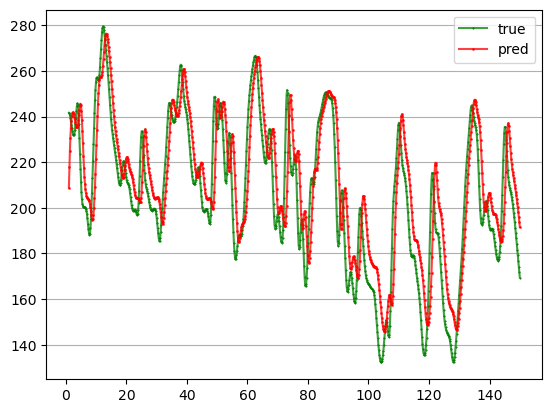

In [39]:
setup_seed(20)
path = os.path.abspath(os.path.dirname(os.getcwd()))
LSTM_PATH = path + '/models/Univariate_single_step_Lst.pkl' #最佳模型保存路径
LSTM_PATH = LSTM_PATH.replace("\\", "/") #torch.save()不能保存windows路径，需要替换

file_name='data.csv'
data=load_data(file_name)
arg = args.us_args_parser() #导入单步模型参数
flag = 'us' # 表示使用单变量单步长的数据

Dtr, Val, Dte, m, n = data_process(data,arg, flag)   
train(arg, Dtr, Val, LSTM_PATH)
test(arg, Dte, LSTM_PATH, m, n)


# 3PyTorch中利用LSTMCell搭建多层LSTM实现时间序列预测

C:\Users\LYH\AppData\Local\Temp\ipykernel_14812\2477230518.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols].fillna(df[num_cols].mean(), inplace=True) #填补缺失值


data processing...


 67%|██████▋   | 50/75 [12:46<06:21, 15.24s/it]

epoch 049 train_loss 0.00251338 val_loss 0.00218568


100%|██████████| 75/75 [18:59<00:00, 15.20s/it]


loading models...
predicting...


100%|██████████| 175/175 [00:01<00:00, 160.29it/s]


rmse: 19.67206345470452
mape: 6.430463409283052
smape: 6.4496081898850015


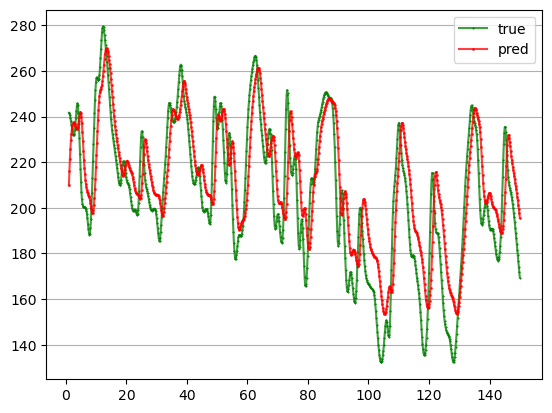

In [40]:
setup_seed(20)
path = os.path.abspath(os.path.dirname(os.getcwd()))
LSTM_PATH = path + '/models/Univariate_single_step_LstmCells.pkl' #最佳模型保存路径
LSTM_PATH = LSTM_PATH.replace("\\", "/") #torch.save()不能保存windows路径，需要替换

file_name='data.csv'
data=load_data(file_name)
arg = args.us_args_parser() #导入单步模型参数
flag = 'us' # 表示使用单变量单步长的数据

Dtr, Val, Dte, m, n = data_process(data,arg, flag)   
train(arg, Dtr, Val, LSTM_PATH,flags=1)
test(arg, Dte, LSTM_PATH, m, n,flags=1)

# 4.PyTorch搭建LSTM实现多变量时间序列预测（负荷预测）

C:\Users\LYH\AppData\Local\Temp\ipykernel_14812\2477230518.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols].fillna(df[num_cols].mean(), inplace=True) #填补缺失值


data processing...


 67%|██████▋   | 50/75 [01:27<00:48,  1.93s/it]

epoch 049 train_loss 0.00168948 val_loss 0.00185118


100%|██████████| 75/75 [02:10<00:00,  1.75s/it]


loading models...
predicting...


100%|██████████| 175/175 [00:00<00:00, 1590.17it/s]


rmse: 17.748594881097937
mape: 5.884691343962261
smape: 5.82203297044997


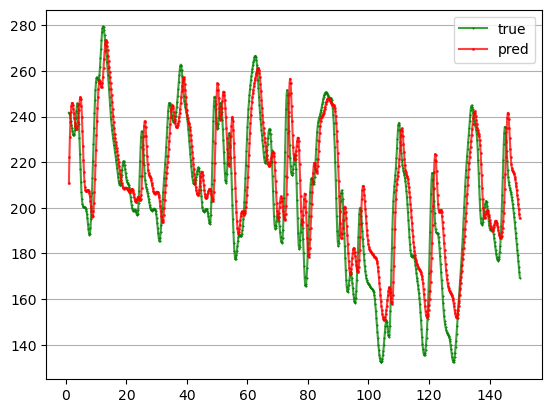

In [42]:
setup_seed(20)
path = os.path.abspath(os.path.dirname(os.getcwd()))
LSTM_PATH = path + '/models/Multivariable_single_step_Lstm.pkl'
LSTM_PATH = LSTM_PATH.replace("\\", "/") #torch.save()不能保存windows路径，需要替换

file_name='data.csv'
data=load_data(file_name)
arg = args.ms_args_parser() 
arg.bidirectional = False #多变量单步处理中设置单向LSTM

flag = 'ms' # 表示使用多变量单步长的数据

Dtr, Val, Dte, m, n = data_process(data,arg, flag)   
train(arg, Dtr, Val, LSTM_PATH)
test(arg, Dte, LSTM_PATH, m, n)

# 5.PyTorch搭建双向LSTM实现时间序列预测（负荷预测）

从你打印的 `seq` 大小来看，大部分的 `seq` 大小都是 `[30, 24, 7]`，这可能是你的批量大小为30，序列长度为24，每个序列有7个特征。然而，有一个 `seq` 的大小是 `[24, 24, 7]`，这可能是因为在数据的最后一个批次，数据不足以形成一个完整的批次，所以大小变为了24。

这就是为什么你的模型期望的隐藏层大小为 `(2, 24, 64)`，但实际得到的隐藏层大小为 `[2, 30, 64]`。你的模型可能是基于批量大小为24来设计的，但大部分的 `seq` 大小都是30。

原来的双向LSTM模型隐藏层构建有问题,在初始化隐藏状态 ho 和c0时，使用了固定的批量大小self.batch size 。
这意味着，无论输入数据的批量大小是多少，隐藏状态的批量大小总是固定的。
  
这就是为什么当最后一个输入数据的批量大小少于self.batch size 时，会遇到问题。解决办法：

1. **丢弃最后一个批次**：在创建 `DataLoader` 时，你可以设置 `drop_last=True`，这样在最后一个批次数据不足时，它会被丢弃，不会被送入模型。
2. **修改模型**：在前向传播时.通过 input seq.size(o)动态地获取批量大小，然后用这个批量大小来初始化隐藏状态,避免最后一个批次样本量不足时，导致批次大小和预期的不匹配

C:\Users\LYH\AppData\Local\Temp\ipykernel_14812\2477230518.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols].fillna(df[num_cols].mean(), inplace=True) #填补缺失值


data processing...


 67%|██████▋   | 50/75 [01:59<01:01,  2.45s/it]

epoch 049 train_loss 0.00170305 val_loss 0.00195474


100%|██████████| 75/75 [03:02<00:00,  2.43s/it]


loading models...
predicting...


100%|██████████| 175/175 [00:00<00:00, 1258.87it/s]


rmse: 17.65879523777932
mape: 5.761943833800664
smape: 5.724198917016474


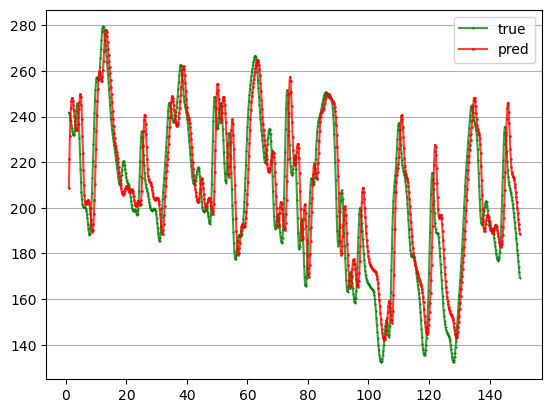

In [43]:
#原来的双向LSTM构建的不好，又没有修改DataLoader的drop_last，导致最后一个批次样本量不足30，所以报错了
setup_seed(20)
path = os.path.abspath(os.path.dirname(os.getcwd()))
LSTM_PATH = path + '/models/Multivariable_single_step_BiLstm.pkl'
LSTM_PATH = LSTM_PATH.replace("\\", "/") #torch.save()不能保存windows路径，需要替换

file_name='data.csv'
data=load_data(file_name)
arg = args.ms_args_parser()
arg.bidirectional = True #双向LSTM
flag = 'ms' 

Dtr, Val, Dte, m, n = data_process(data,arg, flag)   
train(arg, Dtr, Val, LSTM_PATH)
test(arg, Dte, LSTM_PATH, m, n)

# 6.PyTorch搭建LSTM实现多变量多步长时间序列预测（一）：直接多输出

C:\Users\LYH\AppData\Local\Temp\ipykernel_14812\2477230518.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols].fillna(df[num_cols].mean(), inplace=True) #填补缺失值
100%|██████████| 50/50 [01:58<00:00,  2.37s/it]


epoch 049 train_loss 0.00322936 val_loss 0.00440618
loading models...
predicting...


100%|██████████| 43/43 [00:00<00:00, 1134.02it/s]

rmse: 24.895956255590413
mape: 8.271300903288134
smape: 8.123931955671573


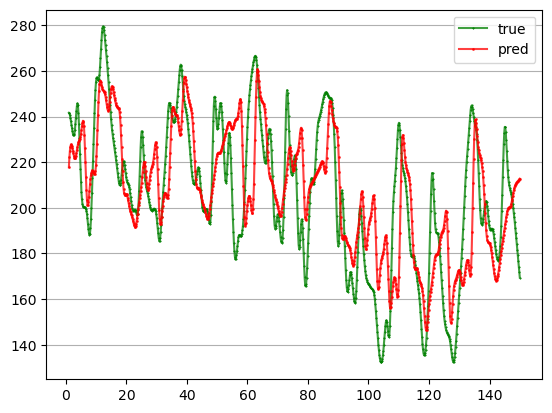

In [44]:
#原word用的是双向LSTM,CSDN是单向LSTM
setup_seed(20)
path = os.path.abspath(os.path.dirname(os.getcwd()))
LSTM_PATH = path + '/models/Multivariable_multi_step_BiLstm.pkl'
LSTM_PATH = LSTM_PATH.replace("\\", "/") #torch.save()不能保存windows路径，需要替换

file_name='data.csv'
data=load_data(file_name)
arg = args.mo_args_parser()
flag = 'mo'

Dtr, Val, Dte, m, n = data_process(data,arg, flag)   
train(arg, Dtr, Val, LSTM_PATH)
test(arg, Dte, LSTM_PATH, m, n)

# 7.多变量多步长时间序列预测（二）：单步滚动预测

In [17]:
#有bug，它后来调了batch=1去预测下一个，原来参数配置的是batch=30，真实值和预测的数量正好差了30倍（没想好咋Debug，直接batch都统一为1）
setup_seed(20)
path = os.path.abspath(os.path.dirname(os.getcwd()))
LSTM_PATH = path + '/models/Multivariable_multi_step_rolling.pkl'
LSTM_PATH = LSTM_PATH.replace("\\", "/") #torch.save()不能保存windows路径，需要替换

file_name='data.csv'
data=load_data(file_name)
arg = args.sss_args_parser()
arg.epochs =10
flag = 'sss' 

Dtr, Val, Dte, m, n = data_process(data,arg, flag)   
train(arg, Dtr, Val, LSTM_PATH)

ss_rolling_test(arg, Dte, LSTM_PATH, m, n) #单步滚动预测的测试代码不一样

C:\Users\LYH\AppData\Local\Temp\ipykernel_18588\2477230518.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols].fillna(df[num_cols].mean(), inplace=True) #填补缺失值
100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


loading models...
predicting...


100%|██████████| 15/15 [00:00<00:00, 75.82it/s]


ValueError: operands could not be broadcast together with shapes (5220,) (174,) 

# 8.多变量多步长时间序列预测（三）：多模型单步预测

C:\Users\LYH\AppData\Local\Temp\ipykernel_14812\2477230518.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols].fillna(df[num_cols].mean(), inplace=True) #填补缺失值
100%|██████████| 30/30 [01:16<00:00,  2.53s/it]


loading models...
predicting...
rmse: 28.85469798840421
mape: 9.609521031490138
smape: 9.403189057164228


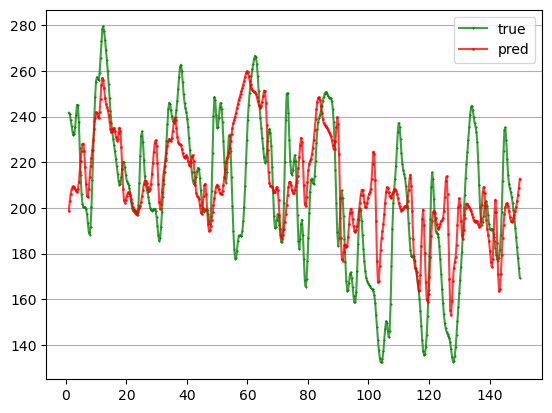

In [45]:
path = os.path.abspath(os.path.dirname(os.getcwd()))
path=path.replace("\\", "/")
#创建列表，便于模型遍历
LSTM_PATH = [
        path+'/models/mmss/MultiModel_sigle_step0.pkl',
        path+'/models/mmss/MultiModel_sigle_step1.pkl',
        path+'/models/mmss/MultiModel_sigle_step2.pkl',
        path+'/models/mmss/MultiModel_sigle_step3.pkl',
        path+'/models/mmss/MultiModel_sigle_step4.pkl',
        path+'/models/mmss/MultiModel_sigle_step5.pkl',
        path+'/models/mmss/MultiModel_sigle_step6.pkl',
        path+'/models/mmss/MultiModel_sigle_step7.pkl',
        path+'/models/mmss/MultiModel_sigle_step8.pkl',
        path+'/models/mmss/MultiModel_sigle_step9.pkl',
        path+'/models/mmss/MultiModel_sigle_step10.pkl',
        path+'/models/mmss/MultiModel_sigle_step11.pkl',
    ]
file_name='data.csv'
data=load_data(file_name)
arg = args.mmss_args_parser()
arg.epochs =30

flag = 'mmss'
Dtrs, Vals, Dtes, m, n = data_process(data,arg, flag)
for Dtr, Val, path in zip(Dtrs, Vals, LSTM_PATH):
    train(arg, Dtr, Val, path)

arg.batch_size = 1
Dtrs, Vals, Dtes, m, n = data_process(data,arg, flag)
m_test(arg, Dtes, LSTM_PATH, m, n)

# 9.多变量多步长时间序列预测（四）：多模型滚动预测

In [ ]:
path = os.path.abspath(os.path.dirname(os.getcwd()))
path=path.replace("\\", "/")
#创建列表，便于模型遍历
LSTM_PATH = [
        path+'/models/mms/MultiModel_rooling_step0.pkl',
        path+'/models/mms/MultiModel_rooling_step1.pkl',
        path+'/models/mms/MultiModel_rooling_step2.pkl',
        path+'/models/mms/MultiModel_rooling_step3.pkl',
        path+'/models/mms/MultiModel_rooling_step4.pkl',
        path+'/models/mms/MultiModel_rooling_step5.pkl',
        path+'/models/mms/MultiModel_rooling_step6.pkl',
        path+'/models/mms/MultiModel_rooling_step7.pkl',
        path+'/models/mms/MultiModel_rooling_step8.pkl',
        path+'/models/mms/MultiModel_rooling_step9.pkl',
        path+'/models/mms/MultiModel_rooling_step10.pkl',
        path+'/models/mms/MultiModel_rooling_step11.pkl',
    ]
file_name='data.csv'
data=load_data(file_name)
arg = args.mms_args_parser()
arg.epochs =30
flag = 'mms' #多模型滚动预测
Dtrs, Vals, Dtes, m, n = data_process(data,arg, flag)
for Dtr, Val, path in zip(Dtrs, Vals, LSTM_PATH):
    train(arg, Dtr, Val, path)

arg.batch_size = 1
Dtrs, Vals, Dtes, m, n = data_process(data,arg, flag)
mms_rolling_test(arg, Dtes, LSTM_PATH, m, n)

C:\Users\LYH\AppData\Local\Temp\ipykernel_17632\3448789555.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols].fillna(df[num_cols].mean(), inplace=True) #填补缺失值
 30%|███       | 9/30 [00:31<01:13,  3.49s/it]


KeyboardInterrupt: 

# 10.多变量多步长时间序列预测（五）：seq2seq

C:\Users\LYH\AppData\Local\Temp\ipykernel_14812\2477230518.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols].fillna(df[num_cols].mean(), inplace=True) #填补缺失值
100%|██████████| 50/50 [12:29<00:00, 15.00s/it]


epoch 049 train_loss 0.00508318 val_loss 0.00643684
loading models...
predicting...


100%|██████████| 14/14 [00:00<00:00, 144.98it/s]

rmse: 32.20740514120256
mape: 10.211314912544339
smape: 10.376939832606451


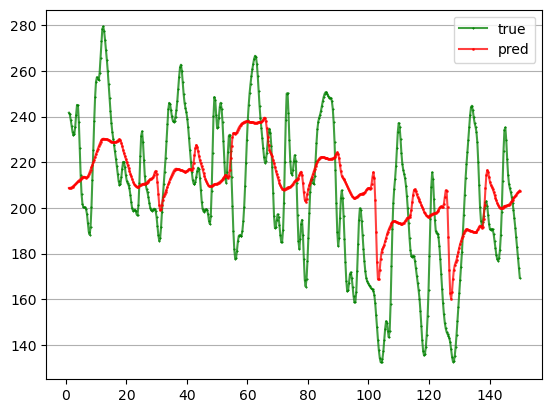

In [46]:
setup_seed(20)

path = os.path.abspath(os.path.dirname(os.getcwd()))
LSTM_PATH = path + '/models/seq2seq.pkl'
LSTM_PATH = LSTM_PATH.replace("\\", "/") #torch.save()不能保存windows
file_name='data.csv'
data=load_data(file_name)

arg = args.seq2seq_args_parser()
#arg.epochs = 75
flag = 'seq2seq'
Dtr, Val, Dte, m, n = data_process(data,arg, flag)   
seq2seq_train(arg, Dtr, Val, LSTM_PATH)
seq2seq_test(arg, Dte, LSTM_PATH, m, n)


# 13.PyTorch搭建LSTM实现多变量输入多变量输出时间序列预测（多任务学习）

C:\Users\LYH\AppData\Local\Temp\ipykernel_14812\2477230518.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols].fillna(df[num_cols].mean(), inplace=True) #填补缺失值
C:\Users\LYH\AppData\Local\Temp\ipykernel_14812\3326470857.py:272: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop([train.columns[0]], axis=1, inplace=True)


C:\Users\LYH\AppData\Local\Temp\ipykernel_14812\3326470857.py:273: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val.drop([val.columns[0]], axis=1, inplace=True)
C:\Users\LYH\AppData\Local\Temp\ipykernel_14812\3326470857.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop([test.columns[0]], axis=1, inplace=True)
 67%|██████▋   | 50/75 [01:41<00:48,  1.94s/it]

epoch 049 train_loss 0.00626096 val_loss 0.00873749


100%|██████████| 75/75 [02:31<00:00,  2.02s/it]


loading models...
predicting...


100%|██████████| 9/9 [00:00<00:00, 693.57it/s]

rmse: 44.50925133975894
mape: 7.262014598530908
smape: 7.328443933614256
rmse: 37.59160461057685
mape: 12.82038106946802
smape: 12.12123386376986
rmse: 218.3101512158069
mape: 9.715660694043017
smape: 10.250360959370791


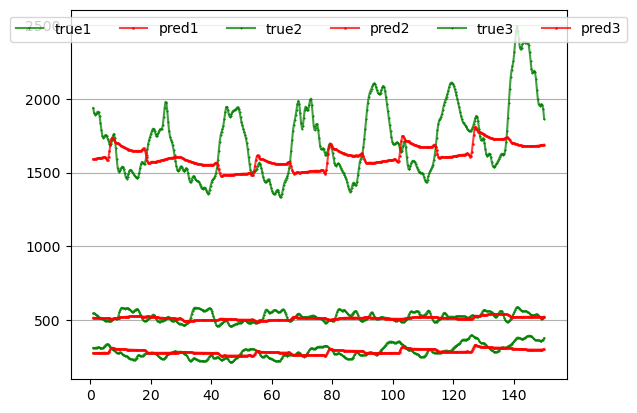

In [47]:
#mtl_data1有bug，损失为nan
#多任务学习使用数据集mlt_data_2.csv
setup_seed(20)
path = os.path.abspath(os.path.dirname(os.getcwd()))
LSTM_PATH = path + '/models/mtl.pkl'
LSTM_PATH = LSTM_PATH.replace("\\", "/") #torch.save()不能保存windows路径，需要替换

if __name__ == '__main__':
    arg = args.multi_task_args_parser()
    flag = 'mtl'
    # Dtr, Val, Dte, m, n = load_data(args, flag, args.batch_size)
    # mtl_train(args, Dtr, Val, LSTM_PATH)
    # mtl_test(args, Dte, LSTM_PATH, m, n)

    Dtr, Val, Dte, scaler = nn_seq_mtl(seq_len=(arg.seq_len), B=arg.batch_size, pred_step_size=(arg.pred_step_size))
    mtl_train(arg, Dtr, Val, LSTM_PATH)
    mtl_test(arg, Dte, scaler, LSTM_PATH)

# 14.ANN实现时间序列预测（风速预测）

# 15.CNN实现时间序列预测（风速预测）

data processing...


C:\Users\LYH\AppData\Local\Temp\ipykernel_3692\2477230518.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols].fillna(df[num_cols].mean(), inplace=True) #填补缺失值


training...
epoch 000 train_loss 0.03435656 val_loss 0.01015820
epoch 001 train_loss 0.00761473 val_loss 0.00993191
epoch 002 train_loss 0.00646791 val_loss 0.00840211
epoch 003 train_loss 0.00646603 val_loss 0.00955684
epoch 004 train_loss 0.00578031 val_loss 0.00919251
epoch 005 train_loss 0.00553801 val_loss 0.01101993
epoch 006 train_loss 0.00523948 val_loss 0.01107331
epoch 007 train_loss 0.00486140 val_loss 0.00766774
epoch 008 train_loss 0.00467675 val_loss 0.00612512
epoch 009 train_loss 0.00447094 val_loss 0.00732028
epoch 010 train_loss 0.00411485 val_loss 0.00748171
epoch 011 train_loss 0.00385582 val_loss 0.00791454
epoch 012 train_loss 0.00377140 val_loss 0.00852073
epoch 013 train_loss 0.00360933 val_loss 0.00746707
epoch 014 train_loss 0.00341619 val_loss 0.00658444
epoch 015 train_loss 0.00328469 val_loss 0.00805859
epoch 016 train_loss 0.00324461 val_loss 0.00868855
epoch 017 train_loss 0.00310896 val_loss 0.00744375
epoch 018 train_loss 0.00305460 val_loss 0.00875406


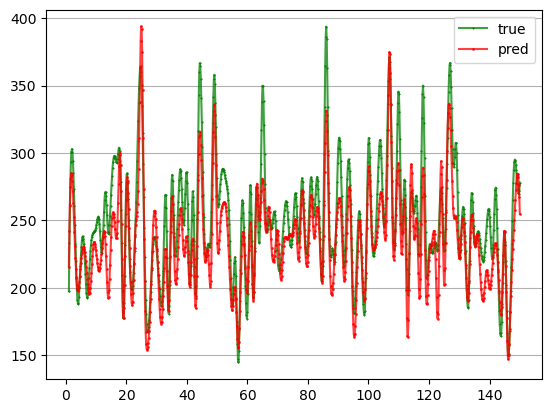

In [14]:
setup_seed(20)
path = os.path.abspath(os.path.dirname(os.getcwd()))
CNN_PATH = path + '/models/mtl.pkl'
CNN_PATH = CNN_PATH.replace("\\", "/") #torch.save()不能保存windows路径，需要替换

# 数据处理
def nn_seq(file_name, B):
    print('data processing...')
    dataset = load_data(file_name)
    # split
    train = dataset[:int(len(dataset) * 0.6)]
    val = dataset[int(len(dataset) * 0.6):int(len(dataset) * 0.8)]
    test = dataset[int(len(dataset) * 0.8):len(dataset)]
    m, n = np.max(train[train.columns[1]]), np.min(train[train.columns[1]])

    def process(data):
        load = data[data.columns[1]]  # 第二列是负荷
        data = data.values.tolist()
        load = (load - n) / (m - n)  # 归一化
        load = load.tolist()
        # 将过去24个时刻的特征和下一个时刻的目标值组合成一个样本
        seq = []
        for i in range(len(data) - 24):
            train_seq = []
            train_label = []
            for j in range(i, i + 24):
                x = [load[j]]
                for c in range(2, 8):
                    x.append(data[j][c])
                train_seq.append(x)
            train_label.append(load[i + 24])
            train_seq = torch.FloatTensor(train_seq)
            train_label = torch.FloatTensor(train_label).view(-1)
            seq.append((train_seq, train_label))

        seq = MyDataset(seq)  # 封装数据

        seq = DataLoader(dataset=seq, batch_size=B, shuffle=True, num_workers=0, drop_last=True)  # 批量加载数据

        return seq

    Dtr = process(train)
    Val = process(val)
    Dte = process(test)

    return Dtr, Val, Dte, m, n

file_name='data.csv'
# 批处理大小和输入数据的维度
B, input_size = 15, 7
Dtr, Val, Dte, MAX, MIN = nn_seq(file_name, B)
CNN_train(Dtr, Val,CNN_PATH)
CNN_test(Dte, MAX, MIN,CNN_PATH)

# 16.CNN-LSTM混合模型实现多变量多步长时间序列预测（负荷预测）

C:\Users\LYH\AppData\Local\Temp\ipykernel_3692\2477230518.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols].fillna(df[num_cols].mean(), inplace=True) #填补缺失值
 17%|█▋        | 50/300 [02:11<10:56,  2.63s/it]

epoch 049 train_loss 0.00412810 val_loss 0.00617281


 33%|███▎      | 99/300 [04:12<08:32,  2.55s/it]


Early stopping
loading models...
predicting...


100%|██████████| 43/43 [00:00<00:00, 899.24it/s]

rmse: 32.690632286436994
mape: 10.080844502248535
smape: 10.604225457989958


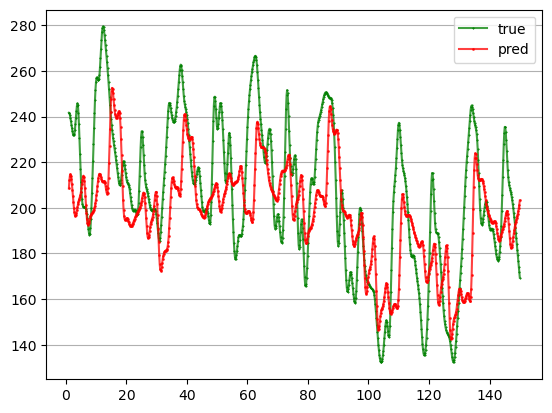

In [15]:
setup_seed(20)
path = os.path.abspath(os.path.dirname(os.getcwd()))
LSTM_PATH = path + '/models/CNN-LSTM.pkl'
LSTM_PATH = LSTM_PATH.replace("\\", "/") #torch.save()不能保存windows路径，需要替换

file_name='data.csv'
data=load_data(file_name)
flag = 'mo'
arg = args.cl_mm_args_parser()
arg.epochs = 300
Dtr, Val, Dte, m, n = data_process(data,arg, flag)
train(arg, Dtr, Val, LSTM_PATH,flags=2) #flags=2表示CNN-LSTM
test(arg, Dte, LSTM_PATH, m, n,flags=2)

# 17.Transformer实现多变量多步长时间序列预测（负荷预测）

C:\Users\LYH\AppData\Local\Temp\ipykernel_1680\2477230518.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols].fillna(df[num_cols].mean(), inplace=True) #填补缺失值


data processing...


 67%|██████▋   | 50/75 [15:21<06:07, 14.69s/it]

epoch 049 train_loss 0.01297259 val_loss 0.00908172


100%|██████████| 75/75 [21:13<00:00, 16.98s/it]


loading models...
predicting...


100%|██████████| 44/44 [00:00<00:00, 323.15it/s]


rmse: 42.575619167056836
mape: 12.62098084119316
smape: 12.788786575577449


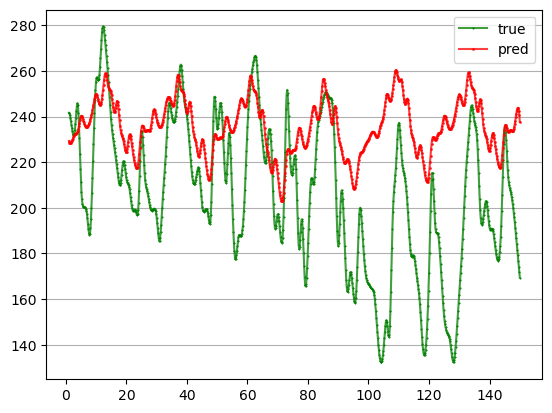

In [13]:
setup_seed(20)

path = os.path.abspath(os.path.dirname(os.getcwd()))
LSTM_PATH = path + '/models/Transformer.pkl'
LSTM_PATH = LSTM_PATH.replace("\\", "/") #torch.save()不能保存windows路径，需要替换

file_name='data.csv'
data=load_data(file_name)
flag = 'mm'
arg = args.trans_args_parser()
arg.epochs = 75
Dtr, Val, Dte, m, n = data_process(data,arg, flag)

train(arg, Dtr, Val, LSTM_PATH,flags=3) #flags=3表示使用Transformer
test(arg, Dte, LSTM_PATH, m, n,flags=3)